Image Colourization

Load the required libraries

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt 
import tensorflow as tf


from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import keras


random.seed(6)
np.random.seed(6)


from skimage import color, transform
from skimage.io import imsave
import cv2

 # Load and Preprocess the dataset

Our dataset is stored on Google drive. So we use this command to connect to it. 

If you are testing this locally, can ignore this. 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This is used to change directories to where the dataset files are located

In [3]:
%cd gdrive/MyDrive/image-dataset

/content/gdrive/MyDrive/4107fm


In [4]:
'''
Two options for loading the data. If you would like, can just open the rgb image 
file and process the data using the following cells. 

Another option is to open the preprocessed files, but this takes up more ram to 
store everything at once. 

'''
# ======================== LAB ==============================

# L_channel = np.load('facesL.npz', allow_pickle=True)
# A_channel = np.load('facesA.npz', allow_pickle=True)
# B_channel = np.load('facesB.npz', allow_pickle=True)


# ======================== RGB ===============================

x_train = np.load('facesRGB.npz', allow_pickle=True)


In [5]:
# From the file loaded, retrieve the numpy array containing the 
# data. This can take ~ 1 minute.

x_train = x_train.f.arr_0
x_train = np.array(x_train)
x_train.shape

(10000, 218, 178, 3)

Shuffle the data. This is SUPER important. Since the imagenet sample dataset is ordered by class. To get a good representation of all classes in the model training, it is important to shuffle it beforehand. 

In [6]:
np.random.shuffle(x_train)

Uncomment this cell if the data has already been saved based on the 3 channels independently 

In [7]:
# L_channel = L_channel.f.arr_0
# A_channel = A_channel.f.arr_0
# B_channel = B_channel.f.arr_0

# print(L_channel.shape)
# print(A_channel.shape)
# print(B_channel.shape)

# L_channel = np.array(L_channel)
# A_channel = np.array(A_channel)
# B_channel = np.array(B_channel)


Select the number of images used for training

In [8]:
num_images = 5000

Loop through all the images and resize them. This is important since the imagenet dataset has various sized images. The model further below is based on having only one specific dimension (224x224)

The reason we chose 224x224 was because that is the input to the models that perform the best such as vgg and resnet 

Training Set

In [9]:
image_array = []

for i in range(num_images):
  # resize the image using the cv2 library
  image_array.append(cv2.resize(x_train[i], dsize=(224, 224), interpolation=cv2.INTER_CUBIC))

image_array = np.array(image_array)

print(image_array.shape)

(5000, 224, 224, 3)


Test Set

In [10]:
test_images = []
num_images_test = 500

for i in range(num_images_test):
  # keep adding images past the images we chose for training 
  test_images.append(cv2.resize(x_train[num_images+i], dsize=(224, 224), interpolation=cv2.INTER_CUBIC))

test_images = np.array(test_images)

In [11]:
# Remove the large array that is no longer going to be used. 
# Free up ram 

del x_train

In [12]:
'''
Purpose: normalize the image values for the different colour channel types
         between 0 and 1. 
Input: image_input, numpy array containing the image pixel values
       channel_type, the type of channel to normalize. It depends since different
       channels have different ranges. 
'''
def normalize_image(image_input, channel_type):
  if channel_type == 'rgb':
    return image_input / 255.0
  elif channel_type == 'AB':
    return image_input / 128.0
  elif channel_type == 'L':
    return image_input / 100.0

In [13]:
'''
Purpose: Convert the rgb images to LAB channels
Input: the image numpy array containing all the images to be converted
Output: the L channels and the AB channels 


'''
def get_convert_to_lab(image_array):

  L_channel = []
  AB_channel = []

  for i in range(image_array.shape[0]):
    
    image_converted = color.rgb2lab(normalize_image(
                                        image_input = image_array[i], 
                                        channel_type='rgb'))
    
    L_channel.append(image_converted[:,:,0])
    AB_channel.append(image_converted[:,:,1:])
    

  L_channel = np.array(L_channel)
  AB_channel = np.array(AB_channel)
  AB_channel = normalize_image(AB_channel, channel_type='AB')

  return L_channel, AB_channel

In [14]:
L_channel, AB_channel = get_convert_to_lab(image_array)

In [15]:
test_images.shape

(500, 224, 224, 3)

In [16]:
L_channel_test, AB_channel_test = get_convert_to_lab(test_images)

In [17]:
L_channel_test.shape

(500, 224, 224)

In [18]:
# Reshape the array to make it 4D tensor. Similar to AB channels except 
# that AB will have 2 channels compared to 1 for the L channels.
L_channel = L_channel.reshape(num_images, 224, 224, 1)
L_channel_test = L_channel_test.reshape(num_images_test, 224, 224, 1)


In [19]:
# Free up some ram by deleting the arrays that will no longer be used
del image_array
del test_images

In [20]:
pre_trained_classifier = tf.keras.applications.ResNet152V2(weights="imagenet")

# select the image dimensions based on the input to the model required
# vgg is 224
# resnet is 224
image_width = 224
image_height = 224


242753536/242745792 [==============================] - 2s 0us/step


In [21]:

import tensorflow.keras.applications.resnet_v2

In [22]:


def classify_with_pretrained(image_array, model_type, model_width, model_height):
    imagenet_predictions = []
    num_channels = 3

    print("Using ", model_type, ", to predict for ", image_array.shape[0], " images.")

    # loop through all the images in the array
    for image in image_array:

        new_image = np.zeros((model_width, model_height, num_channels))
        new_image[:,:, 0] = image.reshape(model_width, model_height)
        new_image[:,:, 1] = image.reshape(model_width, model_height)
        new_image[:,:, 2] = image.reshape(model_width, model_height)

        if model_type == "vgg":
          pass
        elif model_type == "resnet":
          model_preprocess = np.array(tf.keras.applications.resnet_v2.preprocess_input(new_image))

        else:
          print("Unknown model input. Stopping now. ")
          return 

        # since we are predicting one value at a time, need to reshape it before predicting
        model_preprocess = model_preprocess.reshape(1, model_width, model_height, num_channels)
        predicted_value = pre_trained_classifier.predict(model_preprocess, batch_size=1)
        imagenet_predictions.append(predicted_value)   
    
    return imagenet_predictions


In [23]:
imagenet_predictions = classify_with_pretrained(L_channel, "resnet", image_width, image_height)


Using  resnet , to predict for  5000  images.


In [24]:
imagenet_predictions = np.array(imagenet_predictions)

In [25]:
imagenet_predictions.shape

(5000, 1, 1000)

In [26]:
imagenet_predictions = imagenet_predictions.reshape(num_images, 1000)


# Creating the model


The model is based on an encoder-decoder architecture. This is using the functional API from tensorflow and keras. 

To combine the pre-trained model with the predictions, an additional concatination layer was required. This was accomplished with the help of a stackoverflow post found here: https://stackoverflow.com/a/61089524



In [27]:
'''
Purpose: Create the encoder component of the model
Input: activation function to be used all the convolutional layers
       boolean to indicate if batch normalization should be used between the layers

Output: the encoder

'''

def create_encoder(activation_function, input_shape, use_batch_normalization):
  
  input_layer = layers.Input((224, 224, 1,))

  layers_information = [{'filter_size': 32, 'stride': 2},
                   {'filter_size': 32, 'stride': 1},
                   {'filter_size': 64, 'stride': 1},
                   {'filter_size': 64, 'stride': 1},
                   {'filter_size': 128, 'stride': 2},
                   {'filter_size': 128, 'stride': 1},
                   {'filter_size': 128, 'stride': 1},
                   {'filter_size': 256, 'stride': 2},
                   {'filter_size': 256, 'stride': 1},
                   {'filter_size': 256, 'stride': 1},
                   {'filter_size': 512, 'stride': 1}]

  first_layer = True

  for layer_details in layers_information:

    if first_layer:
      input = input_layer
      first_layer = False
    else:
      input = encoder

    encoder = layers.Conv2D(filters=layer_details['filter_size'], 
                            kernel_size=(3,3), 
                            activation=activation_function, 
                            padding='same', strides=layer_details['stride'])(input)
    
    encoder = layers.BatchNormalization() (encoder) if use_batch_normalization else encoder


  return input_layer, encoder

In [28]:
'''
Purpose: decoder component of the model
Input: layer input, the input to the decoder model
       activation_function, the activation function to be used with conv layers
       output_activation, the activation function to be used on the last layer
       boolean to indicate if batch normalization should be used between the layers

'''

def create_decoder(layer_input, activation_function, output_activation, use_batch_normalization):

  # decoder = layers.Conv2D(filters=256, kernel_size=(1,1), activation=activation_function, padding='same')(layer_input)

  layers_information = [{'filter_size': 256, 'upSample': False},
                   {'filter_size': 128, 'upSample': False},
                   {'filter_size': 128, 'upSample': True},
                   {'filter_size': 64, 'upSample': False}, 
                   {'filter_size': 64, 'upSample': False},
                   {'filter_size': 64, 'upSample': True},
                   {'filter_size': 32, 'upSample': False},
                   {'filter_size': 32, 'upSample': False},
                   {'filter_size': 2,  'upSample': True}]

  decoder = layer_input

  for layer_details in layers_information[:-1]:
    decoder = layers.Conv2D(filters=layer_details['filter_size'], 
                            kernel_size=(3,3), 
                            activation=activation_function, 
                            padding='same')(decoder)
    
    decoder = layers.BatchNormalization() (decoder) if use_batch_normalization else decoder

    if layer_details['upSample']:
      decoder = layers.UpSampling2D((2, 2))(decoder)


  decoder = layers.Conv2D(filters=layers_information[-1]['filter_size'], 
                          kernel_size=layers_information[-1]['filter_size'], 
                          activation=output_activation, 
                          padding='same')(decoder)
  
  if layers_information[-1]['upSample']:
      decoder = layers.UpSampling2D((2, 2))(decoder)

  return decoder

Combine the encoder and decoder to create the model 

In [29]:

input_layer, encoder = create_encoder(activation_function='relu',
                                      input_shape=(224, 224, 1,), 
                                      use_batch_normalization=True)

prediction_input = layers.Input((1000,))
combine_layer = layers.RepeatVector(28 ** 2)(prediction_input) 
combine_layer = layers.Reshape(([28, 28, 1000]))(combine_layer)
combine_layer = layers.concatenate([encoder, combine_layer], axis=3) 
combine_layer = layers.Conv2D(filters=256, kernel_size=(1,1), activation='relu', padding='same')(combine_layer)

decoder = create_decoder(layer_input=combine_layer,
                         activation_function='relu',
                         output_activation='tanh', 
                         use_batch_normalization=False)


model = tf.keras.Model(inputs=[input_layer, prediction_input], outputs=decoder)

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

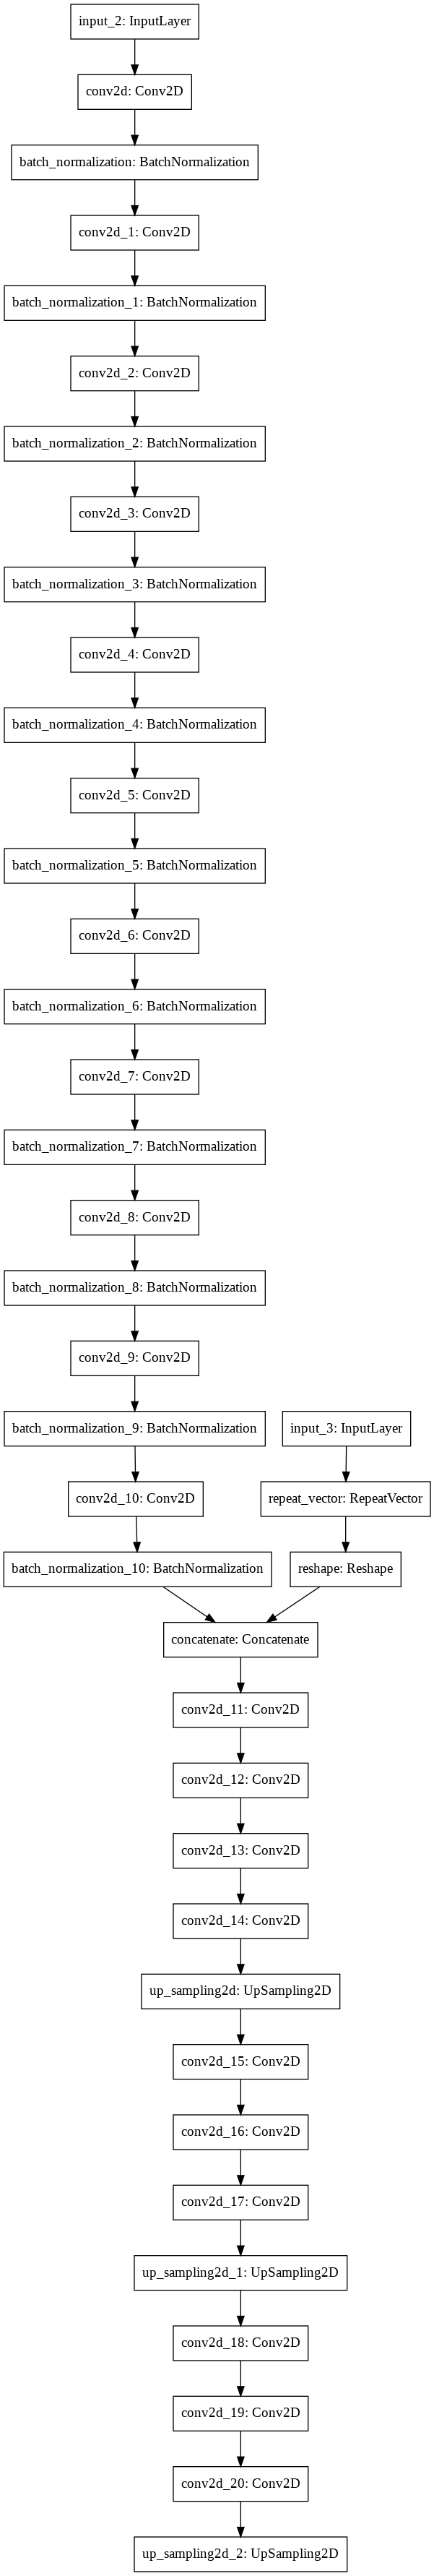

In [31]:
tf.keras.utils.plot_model(model)

In [32]:
# MSE_loss_function = tf.keras.losses.MeanSquaredError()

# model.compile(optimizer='rmsprop', loss=MSE_loss_function, metrics=['accuracy'])

model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])


In [33]:
history = model.fit(x=[L_channel, imagenet_predictions] ,y=AB_channel, batch_size=16, epochs=100, validation_split=0.1)

Epoch 1/100
282/282 [==============================] - 29s 86ms/step - loss: 0.0346 - accuracy: 0.5992 - val_loss: 0.0183 - val_accuracy: 0.5213
Epoch 2/100
282/282 [==============================] - 23s 81ms/step - loss: 0.0086 - accuracy: 0.6014 - val_loss: 0.0087 - val_accuracy: 0.6060
Epoch 3/100
282/282 [==============================] - 23s 80ms/step - loss: 0.0086 - accuracy: 0.6162 - val_loss: 0.0094 - val_accuracy: 0.6201
Epoch 4/100
282/282 [==============================] - 23s 80ms/step - loss: 0.0077 - accuracy: 0.6158 - val_loss: 0.0085 - val_accuracy: 0.5908
Epoch 5/100
282/282 [==============================] - 22s 80ms/step - loss: 0.0080 - accuracy: 0.6164 - val_loss: 0.0081 - val_accuracy: 0.6071
Epoch 6/100
282/282 [==============================] - 23s 80ms/step - loss: 0.0080 - accuracy: 0.6102 - val_loss: 0.0086 - val_accuracy: 0.6155
Epoch 7/100
282/282 [==============================] - 23s 80ms/step - loss: 0.0077 - accuracy: 0.6093 - val_loss: 0.0086 - val_ac

In [37]:
model.save('faces_resnet_100epochs')

INFO:tensorflow:Assets written to: faces_resnet_100epochs/assets


In [38]:
history = model.fit(x=[L_channel, imagenet_predictions] ,y=AB_channel, batch_size=16, epochs=50, validation_split=0.1)

Epoch 1/50
282/282 [==============================] - 23s 80ms/step - loss: 0.0020 - accuracy: 0.7138 - val_loss: 0.0086 - val_accuracy: 0.6110
Epoch 2/50
282/282 [==============================] - 22s 80ms/step - loss: 0.0020 - accuracy: 0.7129 - val_loss: 0.0084 - val_accuracy: 0.6131
Epoch 3/50
282/282 [==============================] - 22s 80ms/step - loss: 0.0020 - accuracy: 0.7144 - val_loss: 0.0083 - val_accuracy: 0.5966
Epoch 4/50
282/282 [==============================] - 22s 80ms/step - loss: 0.0020 - accuracy: 0.7133 - val_loss: 0.0091 - val_accuracy: 0.6022
Epoch 5/50
282/282 [==============================] - 22s 80ms/step - loss: 0.0019 - accuracy: 0.7175 - val_loss: 0.0092 - val_accuracy: 0.6028
Epoch 6/50
282/282 [==============================] - 22s 80ms/step - loss: 0.0020 - accuracy: 0.7158 - val_loss: 0.0084 - val_accuracy: 0.6129
Epoch 7/50
282/282 [==============================] - 22s 80ms/step - loss: 0.0019 - accuracy: 0.7181 - val_loss: 0.0086 - val_accuracy:

In [41]:
model.save('faces_resnet_150epochs')

INFO:tensorflow:Assets written to: faces_resnet_150epochs/assets


# Model Evaluation

Display the results:

In [ ]:
i =0
AB_channel[i].shape

(224, 224, 2)

In [34]:
from matplotlib import pyplot as plt

Using  resnet , to predict for  1  images.


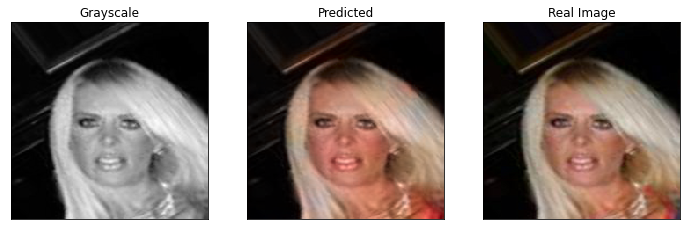

Using  resnet , to predict for  1  images.


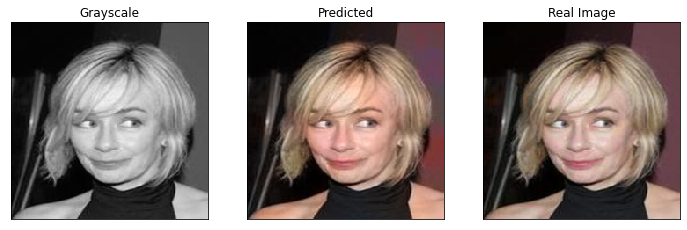

Using  resnet , to predict for  1  images.


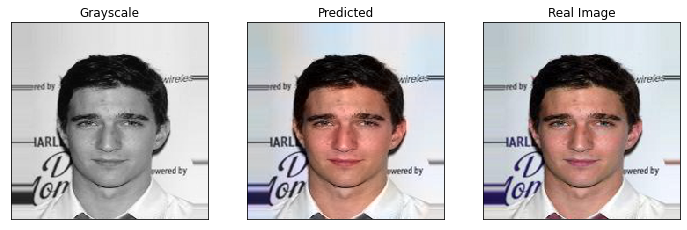

Using  resnet , to predict for  1  images.


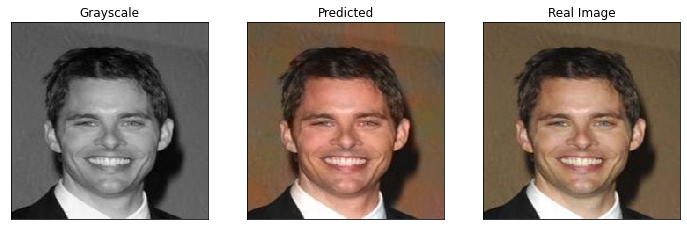

Using  resnet , to predict for  1  images.


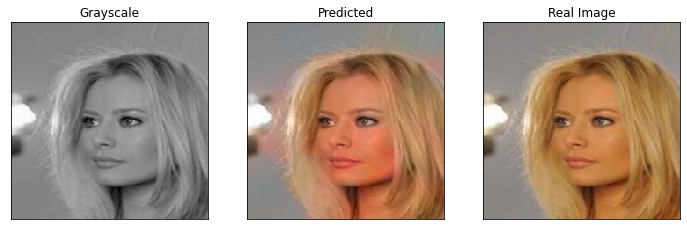

Using  resnet , to predict for  1  images.


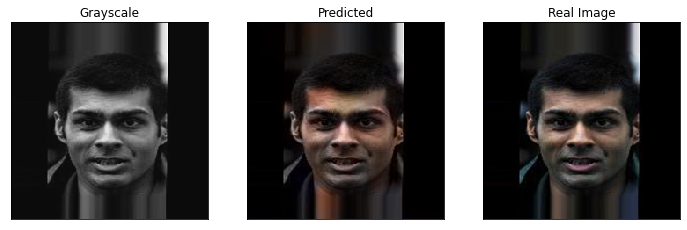

Using  resnet , to predict for  1  images.


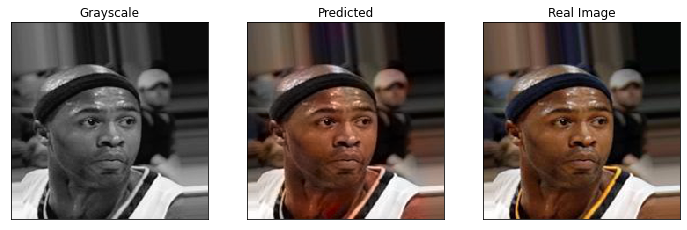

Using  resnet , to predict for  1  images.


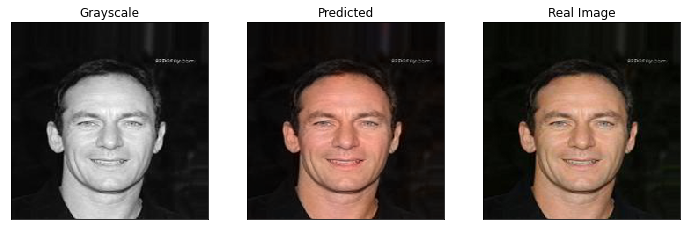

Using  resnet , to predict for  1  images.


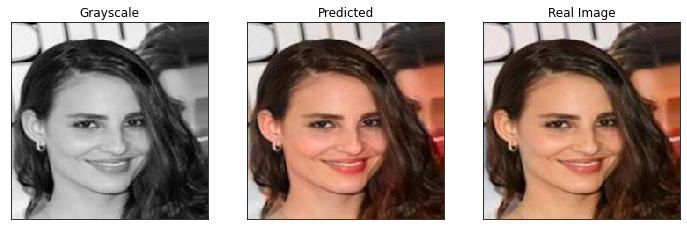

Using  resnet , to predict for  1  images.


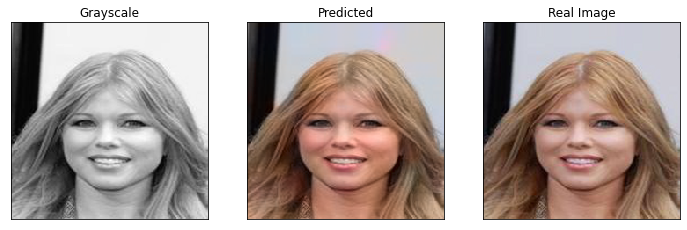

In [39]:
for i in range(10,20):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))


  L_channel_image = L_channel[i].reshape(1,224,224,1)
  image_classification = classify_with_pretrained(L_channel_image, 'resnet', 224, 224)

  
  predicted_AB_channels = model.predict([L_channel_image, image_classification])
  predicted_AB_channels *= 128
  
  image_predicted = np.zeros((224, 224, 3))
  image_predicted[:,:,0] = L_channel[i][:,:,0]
  image_predicted[:,:,1:] = predicted_AB_channels[0]


  actual_image = np.zeros((224, 224, 3))
  actual_image[:,:,0] = L_channel[i][:,:,0]
  actual_image[:,:,1:] = AB_channel[i] * 128

  real_image = color.lab2rgb(actual_image)
  
  image_predicted = color.lab2rgb(image_predicted)

  

  ax[0].imshow(L_channel[i].reshape(224,224), interpolation='nearest', cmap='gray')
  ax[1].imshow(image_predicted, interpolation='nearest')
  ax[2].imshow(real_image, interpolation='nearest')

  ax[0].set_title("Grayscale")
  ax[0].set_xticks([])
  ax[0].set_yticks([])

  ax[1].set_title("Predicted")
  ax[1].set_xticks([])
  ax[1].set_yticks([])

  ax[2].set_title("Real Image")
  ax[2].set_xticks([])
  ax[2].set_yticks([])

  plt.show()

Test Set

Using  resnet , to predict for  1  images.


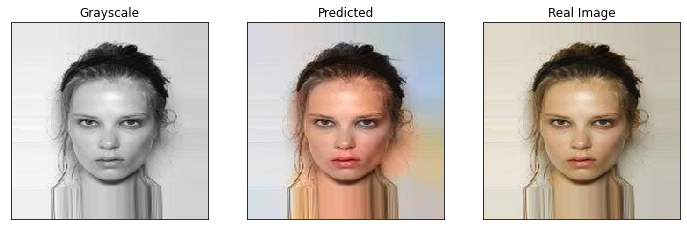

Using  resnet , to predict for  1  images.


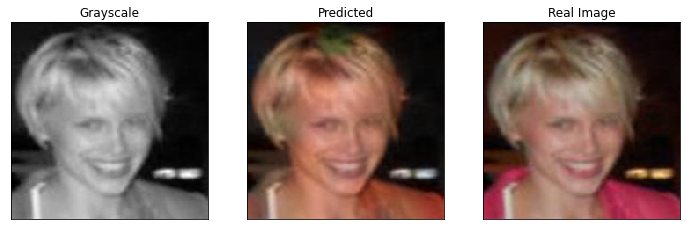

Using  resnet , to predict for  1  images.


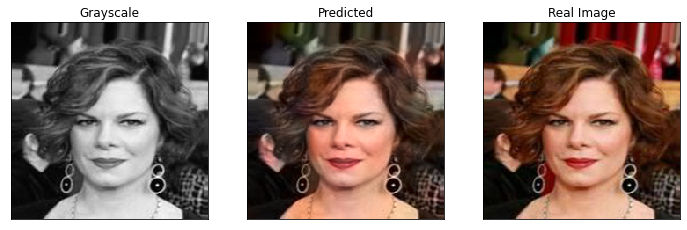

Using  resnet , to predict for  1  images.


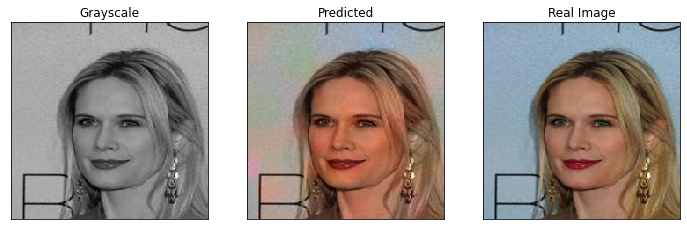

Using  resnet , to predict for  1  images.


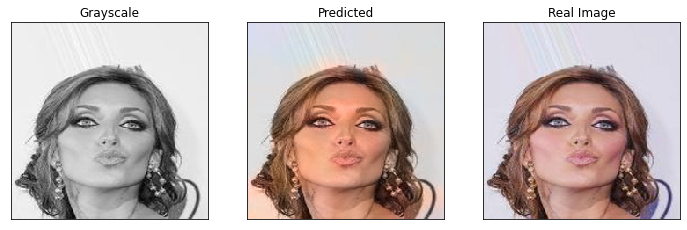

Using  resnet , to predict for  1  images.


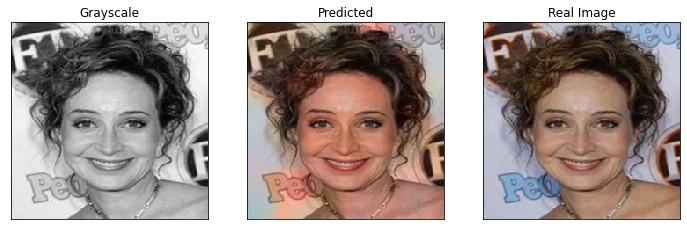

Using  resnet , to predict for  1  images.


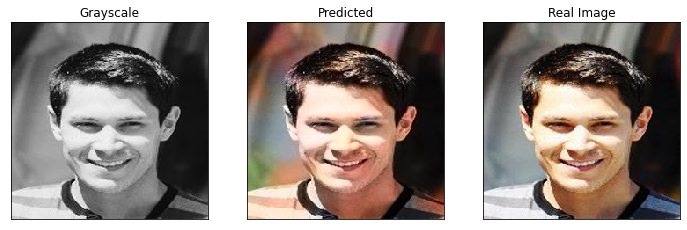

Using  resnet , to predict for  1  images.


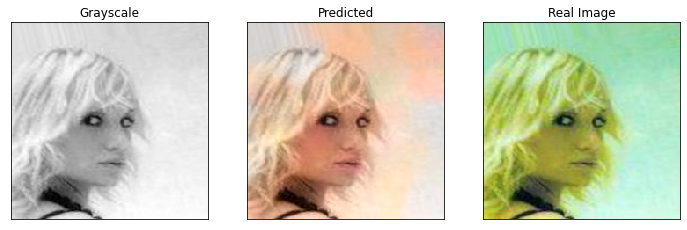

Using  resnet , to predict for  1  images.


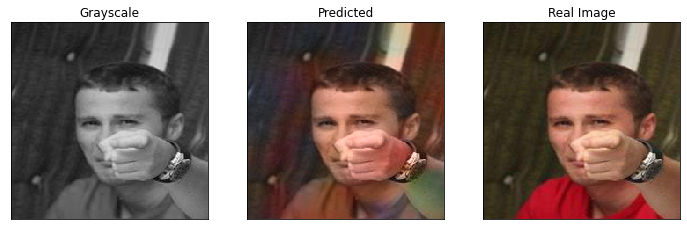

Using  resnet , to predict for  1  images.


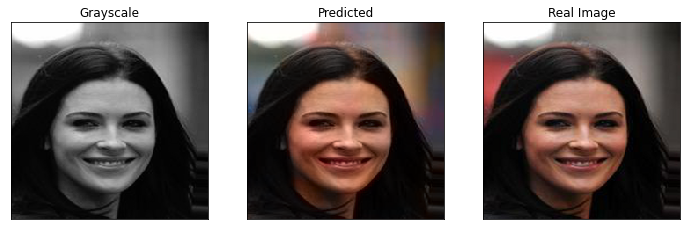

Using  resnet , to predict for  1  images.


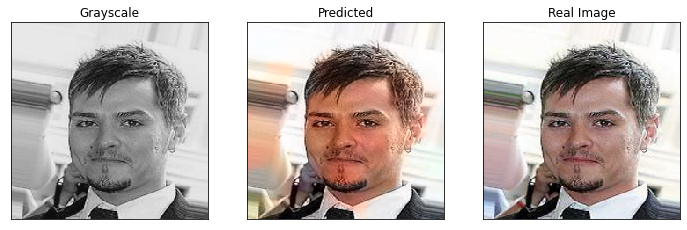

Using  resnet , to predict for  1  images.


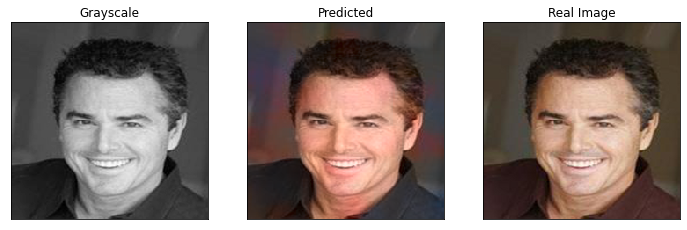

Using  resnet , to predict for  1  images.


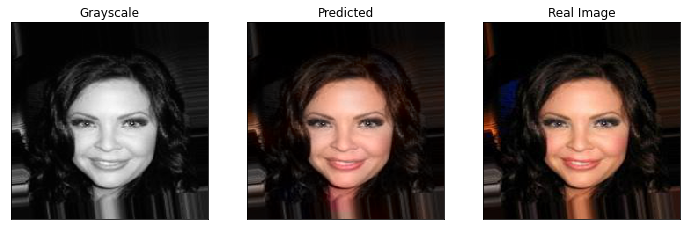

Using  resnet , to predict for  1  images.


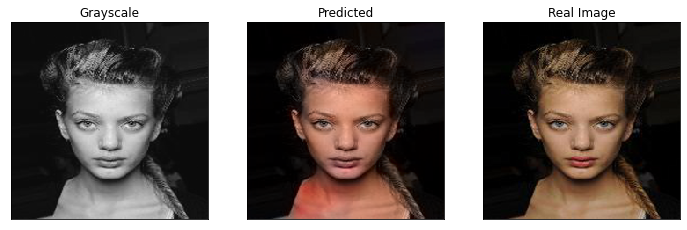

Using  resnet , to predict for  1  images.


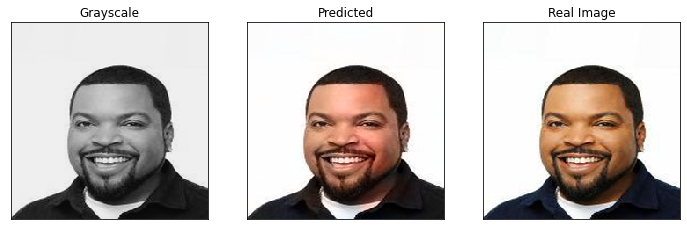

In [40]:
for i in range(15,30):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))


  L_channel_image = L_channel_test[i].reshape(1,224,224,1)
  image_classification = classify_with_pretrained(L_channel_image, 'resnet', 224, 224)

  
  predicted_AB_channels = model.predict([L_channel_image, image_classification])
  predicted_AB_channels *= 128
  
  image_predicted = np.zeros((224, 224, 3))
  image_predicted[:,:,0] = L_channel_test[i][:,:,0]
  image_predicted[:,:,1:] = predicted_AB_channels[0]


  actual_image = np.zeros((224, 224, 3))
  actual_image[:,:,0] = L_channel_test[i][:,:,0]
  actual_image[:,:,1:] = AB_channel_test[i] * 128

  real_image = color.lab2rgb(actual_image)
  
  image_predicted = color.lab2rgb(image_predicted)

  

  ax[0].imshow(L_channel_test[i].reshape(224,224), interpolation='nearest', cmap='gray')
  ax[1].imshow(image_predicted, interpolation='nearest')
  ax[2].imshow(real_image, interpolation='nearest')

  ax[0].set_title("Grayscale")
  ax[0].set_xticks([])
  ax[0].set_yticks([])

  ax[1].set_title("Predicted")
  ax[1].set_xticks([])
  ax[1].set_yticks([])

  ax[2].set_title("Real Image")
  ax[2].set_xticks([])
  ax[2].set_yticks([])

  plt.show()

# End